# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=5,
        fold=4,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_10-46-07/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191849 [00:00<?, ?it/s]

  0%|          | 0/21364 [00:00<?, ?it/s]

  0%|          | 0/53439 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191849 [00:00<?, ?it/s]

  0%|          | 0/53439 [00:00<?, ?it/s]

  0%|          | 0/21364 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.5004 | MulticlassF1Score=0.1159
Batch-30 : CrossEntropyLoss=2.4752 | MulticlassF1Score=0.2143
Batch-45 : CrossEntropyLoss=2.4219 | MulticlassF1Score=0.2621
Batch-60 : CrossEntropyLoss=2.3965 | MulticlassF1Score=0.3290
Batch-75 : CrossEntropyLoss=2.3844 | MulticlassF1Score=0.3768
Batch-90 : CrossEntropyLoss=2.3883 | MulticlassF1Score=0.4107
Batch-105: CrossEntropyLoss=2.3832 | MulticlassF1Score=0.4351
Batch-120: CrossEntropyLoss=2.4125 | MulticlassF1Score=0.4538
Batch-135: CrossEntropyLoss=2.3740 | MulticlassF1Score=0.4682
Batch-150: CrossEntropyLoss=2.3608 | MulticlassF1Score=0.4807
Batch-165: CrossEntropyLoss=2.3389 | MulticlassF1Score=0.4975
Batch-180: CrossEntropyLoss=2.3400 | MulticlassF1Score=0.5115
Batch-195: CrossEntropyLoss=2.3624 | MulticlassF1Score=0.5238
Batch-210: CrossEntropyLoss=2.3552 | MulticlassF1Score=0.5342
Batch-225: CrossEntropyLoss=2.3516 | MulticlassF1Score=0.5446
Batch-226: CrossEntropyLoss=2.3366 | MulticlassF1Score=0.5450

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3495 | MulticlassF1Score=0.6777
Batch-30 : CrossEntropyLoss=2.3486 | MulticlassF1Score=0.6730
Batch-45 : CrossEntropyLoss=2.3554 | MulticlassF1Score=0.6761
Batch-60 : CrossEntropyLoss=2.3485 | MulticlassF1Score=0.6750
Batch-63 : CrossEntropyLoss=2.3780 | MulticlassF1Score=0.6754

Training   : Mean CrossEntropyLoss = 2.4018 | Mean MulticlassF1Score = 0.3968
Validation : Mean CrossEntropyLoss = 2.3494 | Mean MulticlassF1Score = 0.6752

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3463 | MulticlassF1Score=0.6705
Batch-30 : CrossEntropyLoss=2.3562 | MulticlassF1Score=0.6741
Batch-45 : CrossEntropyLoss=2.3434 | MulticlassF1Score=0.6730
Batch-60 : CrossEntropyLoss=2.3524 | MulticlassF1Score=0.6745
Batch-75 : CrossEntropyLoss=2.3312 | MulticlassF1Score=0.6847
Batch-90 : CrossEntropyLoss=2.3231 | MulticlassF1Score=0.7008
Batch-105: CrossEntropyLoss=2.3154 | MulticlassF1Score=0.7129
Batch-120: CrossEntropyLoss=2.3173 | MulticlassF1Score=0.7219
Batch-135: CrossEntropyLoss=2.3176 | MulticlassF1Score=0.7293
Batch-150: CrossEntropyLoss=2.3207 | MulticlassF1Score=0.7350
Batch-165: CrossEntropyLoss=2.3166 | MulticlassF1Score=0.7398
Batch-180: CrossEntropyLoss=2.3158 | MulticlassF1Score=0.7445
Batch-195: CrossEntropyLoss=2.3135 | MulticlassF1Score=0.7478
Batch-210: CrossEntropyLoss=2.3017 | MulticlassF1Score=0.7514
Batch-225: CrossEntropyLoss=2.3150 | MulticlassF1Score=0.7545
Batch-226: CrossEntropyLoss=2.2994 | MulticlassF1Score=0.7546

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3257 | MulticlassF1Score=0.7921
Batch-30 : CrossEntropyLoss=2.3191 | MulticlassF1Score=0.7907
Batch-45 : CrossEntropyLoss=2.3039 | MulticlassF1Score=0.7898
Batch-60 : CrossEntropyLoss=2.2986 | MulticlassF1Score=0.7910
Batch-63 : CrossEntropyLoss=2.3089 | MulticlassF1Score=0.7914

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3248 | Mean MulticlassF1Score = 0.7121
Validation : Mean CrossEntropyLoss = 2.3131 | Mean MulticlassF1Score = 0.7912

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3182 | MulticlassF1Score=0.7893
Batch-30 : CrossEntropyLoss=2.3016 | MulticlassF1Score=0.7916
Batch-45 : CrossEntropyLoss=2.3115 | MulticlassF1Score=0.7937
Batch-60 : CrossEntropyLoss=2.3068 | MulticlassF1Score=0.7972
Batch-75 : CrossEntropyLoss=2.3063 | MulticlassF1Score=0.7986
Batch-90 : CrossEntropyLoss=2.3089 | MulticlassF1Score=0.8033
Batch-105: CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8053
Batch-120: CrossEntropyLoss=2.3110 | MulticlassF1Score=0.8068
Batch-135: CrossEntropyLoss=2.3179 | MulticlassF1Score=0.8072
Batch-150: CrossEntropyLoss=2.3060 | MulticlassF1Score=0.8076
Batch-165: CrossEntropyLoss=2.3069 | MulticlassF1Score=0.8082
Batch-180: CrossEntropyLoss=2.3068 | MulticlassF1Score=0.8088
Batch-195: CrossEntropyLoss=2.3085 | MulticlassF1Score=0.8096
Batch-210: CrossEntropyLoss=2.3251 | MulticlassF1Score=0.8094
Batch-225: CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8100
Batch-226: CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8100

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3037 | MulticlassF1Score=0.8108
Batch-30 : CrossEntropyLoss=2.3068 | MulticlassF1Score=0.8154
Batch-45 : CrossEntropyLoss=2.3060 | MulticlassF1Score=0.8139
Batch-60 : CrossEntropyLoss=2.3083 | MulticlassF1Score=0.8131
Batch-63 : CrossEntropyLoss=2.3063 | MulticlassF1Score=0.8136

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3070 | Mean MulticlassF1Score = 0.8025
Validation : Mean CrossEntropyLoss = 2.3057 | Mean MulticlassF1Score = 0.8129

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8278
Batch-30 : CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8249
Batch-45 : CrossEntropyLoss=2.3080 | MulticlassF1Score=0.8247
Batch-60 : CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8261
Batch-75 : CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8261
Batch-90 : CrossEntropyLoss=2.3000 | MulticlassF1Score=0.8262
Batch-105: CrossEntropyLoss=2.3012 | MulticlassF1Score=0.8267
Batch-120: CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8269
Batch-135: CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8274
Batch-150: CrossEntropyLoss=2.3064 | MulticlassF1Score=0.8269
Batch-165: CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8273
Batch-180: CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8277
Batch-195: CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8276
Batch-210: CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8276
Batch-225: CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8278
Batch-226: CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8279

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3183 | MulticlassF1Score=0.8263
Batch-30 : CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8258
Batch-45 : CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8256
Batch-60 : CrossEntropyLoss=2.3056 | MulticlassF1Score=0.8254
Batch-63 : CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8252

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3012 | Mean MulticlassF1Score = 0.8269
Validation : Mean CrossEntropyLoss = 2.3020 | Mean MulticlassF1Score = 0.8250

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3022 | MulticlassF1Score=0.8240
Batch-30 : CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8289
Batch-45 : CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8305
Batch-60 : CrossEntropyLoss=2.3027 | MulticlassF1Score=0.8308
Batch-75 : CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8312
Batch-90 : CrossEntropyLoss=2.3035 | MulticlassF1Score=0.8298
Batch-105: CrossEntropyLoss=2.3073 | MulticlassF1Score=0.8299
Batch-120: CrossEntropyLoss=2.3047 | MulticlassF1Score=0.8304
Batch-135: CrossEntropyLoss=2.3123 | MulticlassF1Score=0.8302
Batch-150: CrossEntropyLoss=2.3113 | MulticlassF1Score=0.8302
Batch-165: CrossEntropyLoss=2.3096 | MulticlassF1Score=0.8297
Batch-180: CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8304
Batch-195: CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8304
Batch-210: CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8307
Batch-225: CrossEntropyLoss=2.2987 | MulticlassF1Score=0.8305
Batch-226: CrossEntropyLoss=2.3155 | MulticlassF1Score=0.8305

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8262
Batch-30 : CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8255
Batch-45 : CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8263
Batch-60 : CrossEntropyLoss=2.3034 | MulticlassF1Score=0.8265
Batch-63 : CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8266

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3002 | Mean MulticlassF1Score = 0.8298
Validation : Mean CrossEntropyLoss = 2.3014 | Mean MulticlassF1Score = 0.8268

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8338
Batch-30 : CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8319
Batch-45 : CrossEntropyLoss=2.3002 | MulticlassF1Score=0.8332
Batch-60 : CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8348
Batch-75 : CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8341
Batch-90 : CrossEntropyLoss=2.3146 | MulticlassF1Score=0.8339
Batch-105: CrossEntropyLoss=2.3053 | MulticlassF1Score=0.8319
Batch-120: CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8326
Batch-135: CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8323
Batch-150: CrossEntropyLoss=2.3085 | MulticlassF1Score=0.8315
Batch-165: CrossEntropyLoss=2.3018 | MulticlassF1Score=0.8309
Batch-180: CrossEntropyLoss=2.3047 | MulticlassF1Score=0.8311
Batch-195: CrossEntropyLoss=2.3073 | MulticlassF1Score=0.8313
Batch-210: CrossEntropyLoss=2.3025 | MulticlassF1Score=0.8315
Batch-225: CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8321
Batch-226: CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8320

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8271
Batch-30 : CrossEntropyLoss=2.3129 | MulticlassF1Score=0.8284
Batch-45 : CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8271
Batch-60 : CrossEntropyLoss=2.3114 | MulticlassF1Score=0.8280
Batch-63 : CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8277

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2996 | Mean MulticlassF1Score = 0.8325
Validation : Mean CrossEntropyLoss = 2.3012 | Mean MulticlassF1Score = 0.8276

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8311
Batch-30 : CrossEntropyLoss=2.3064 | MulticlassF1Score=0.8330
Batch-45 : CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8297
Batch-60 : CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8317
Batch-75 : CrossEntropyLoss=2.3048 | MulticlassF1Score=0.8315
Batch-90 : CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8312
Batch-105: CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8318
Batch-120: CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8337
Batch-135: CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8356
Batch-150: CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8362
Batch-165: CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8376
Batch-180: CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8385
Batch-195: CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8395
Batch-210: CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8400
Batch-225: CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8406
Batch-226: CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8407

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8445
Batch-30 : CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8467
Batch-45 : CrossEntropyLoss=2.3054 | MulticlassF1Score=0.8434
Batch-60 : CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8433
Batch-63 : CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8432

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2971 | Mean MulticlassF1Score = 0.8342
Validation : Mean CrossEntropyLoss = 2.2965 | Mean MulticlassF1Score = 0.8441

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8498
Batch-30 : CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8480
Batch-45 : CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8484
Batch-60 : CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8498
Batch-75 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8504
Batch-90 : CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8505
Batch-105: CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8508
Batch-120: CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8505
Batch-135: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8500
Batch-150: CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8508
Batch-165: CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8509
Batch-180: CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8512
Batch-195: CrossEntropyLoss=2.2918 | MulticlassF1Score=0.8511
Batch-210: CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8512
Batch-225: CrossEntropyLoss=2.3018 | MulticlassF1Score=0.8509
Batch-226: CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8509

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8462
Batch-30 : CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8458
Batch-45 : CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8429
Batch-60 : CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8436
Batch-63 : CrossEntropyLoss=2.3017 | MulticlassF1Score=0.8436

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2939 | Mean MulticlassF1Score = 0.8504
Validation : Mean CrossEntropyLoss = 2.2963 | Mean MulticlassF1Score = 0.8454

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8517
Batch-30 : CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8521
Batch-45 : CrossEntropyLoss=2.3045 | MulticlassF1Score=0.8521
Batch-60 : CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8523
Batch-75 : CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8526
Batch-90 : CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8518
Batch-105: CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8525
Batch-120: CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8526
Batch-135: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8528
Batch-150: CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8525
Batch-165: CrossEntropyLoss=2.2987 | MulticlassF1Score=0.8521
Batch-180: CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8523
Batch-195: CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8530
Batch-210: CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8536
Batch-225: CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8545
Batch-226: CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8544

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8516
Batch-30 : CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8514
Batch-45 : CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8516
Batch-60 : CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8528
Batch-63 : CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8532

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2927 | Mean MulticlassF1Score = 0.8524
Validation : Mean CrossEntropyLoss = 2.2933 | Mean MulticlassF1Score = 0.8523

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8602
Batch-30 : CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8626
Batch-45 : CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8623
Batch-60 : CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8623
Batch-75 : CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8606
Batch-90 : CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8609
Batch-105: CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8616
Batch-120: CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8614
Batch-135: CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8614
Batch-150: CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8621
Batch-165: CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8630
Batch-180: CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8648
Batch-195: CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8660
Batch-210: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8677
Batch-225: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8693
Batch-226: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.8694

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8845
Batch-30 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8824
Batch-45 : CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8808
Batch-60 : CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8806
Batch-63 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8814

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2882 | Mean MulticlassF1Score = 0.8629
Validation : Mean CrossEntropyLoss = 2.2847 | Mean MulticlassF1Score = 0.8818

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8835
Batch-30 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8908
Batch-45 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8908
Batch-60 : CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8912
Batch-75 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.8901
Batch-90 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8908
Batch-105: CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8911
Batch-120: CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8911
Batch-135: CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8909
Batch-150: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8912
Batch-165: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.8913
Batch-180: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8916
Batch-195: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8911
Batch-210: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.8921
Batch-225: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.8934
Batch-226: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8934

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.9016
Batch-30 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9042
Batch-45 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9055
Batch-60 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9047
Batch-63 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9047

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2808 | Mean MulticlassF1Score = 0.8904
Validation : Mean CrossEntropyLoss = 2.2776 | Mean MulticlassF1Score = 0.9036

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9141
Batch-30 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9139
Batch-45 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9159
Batch-60 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9157
Batch-75 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9171
Batch-90 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9183
Batch-105: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9192
Batch-120: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9193
Batch-135: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9197
Batch-150: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9199
Batch-165: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9199
Batch-180: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9199
Batch-195: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9204
Batch-210: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9206
Batch-225: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9206
Batch-226: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9206

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2835 | MulticlassF1Score=0.9101
Batch-30 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.9100
Batch-45 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9108
Batch-60 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9112
Batch-63 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9117

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2726 | Mean MulticlassF1Score = 0.9184
Validation : Mean CrossEntropyLoss = 2.2753 | Mean MulticlassF1Score = 0.9114

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9262
Batch-30 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9251
Batch-45 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9237
Batch-60 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9245
Batch-75 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9251
Batch-90 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9246
Batch-105: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9247
Batch-120: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9248
Batch-135: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9250
Batch-150: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9247
Batch-165: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9248
Batch-180: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9250
Batch-195: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9245
Batch-210: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9247
Batch-225: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9246
Batch-226: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9246

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9121
Batch-30 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9117
Batch-45 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.9122
Batch-60 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9124
Batch-63 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9131

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2711 | Mean MulticlassF1Score = 0.9248
Validation : Mean CrossEntropyLoss = 2.2747 | Mean MulticlassF1Score = 0.9121

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9251
Batch-30 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9249
Batch-45 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9279
Batch-60 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9278
Batch-75 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9269
Batch-90 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9265
Batch-105: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9254
Batch-120: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9254
Batch-135: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9252
Batch-150: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9253
Batch-165: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9257
Batch-180: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9259
Batch-195: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9261
Batch-210: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9260
Batch-225: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9258
Batch-226: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9258

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.9135
Batch-30 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9112
Batch-45 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.9131
Batch-60 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9131
Batch-63 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9133

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2707 | Mean MulticlassF1Score = 0.9261
Validation : Mean CrossEntropyLoss = 2.2747 | Mean MulticlassF1Score = 0.9130

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9297
Batch-30 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9292
Batch-45 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9285
Batch-60 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9279
Batch-75 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9274
Batch-90 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9272
Batch-105: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9278
Batch-120: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9276
Batch-135: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9277
Batch-150: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9275
Batch-165: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9274
Batch-180: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9273
Batch-195: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9271
Batch-210: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9271
Batch-225: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9270
Batch-226: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9270

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.9125
Batch-30 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9140
Batch-45 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9145
Batch-60 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9134
Batch-63 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9137

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2703 | Mean MulticlassF1Score = 0.9276
Validation : Mean CrossEntropyLoss = 2.2744 | Mean MulticlassF1Score = 0.9125

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9276
Batch-30 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9242
Batch-45 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9263
Batch-60 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9268
Batch-75 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9280
Batch-90 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9277
Batch-105: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9281
Batch-120: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9283
Batch-135: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9282
Batch-150: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9279
Batch-165: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9276
Batch-180: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9277
Batch-195: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9282
Batch-210: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9282
Batch-225: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9281
Batch-226: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9281

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9118
Batch-30 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.9129
Batch-45 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9131
Batch-60 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9141
Batch-63 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.9134

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2699 | Mean MulticlassF1Score = 0.9274
Validation : Mean CrossEntropyLoss = 2.2746 | Mean MulticlassF1Score = 0.9128

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9314
Batch-30 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9305
Batch-45 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9289
Batch-60 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9276
Batch-75 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9282
Batch-90 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9277
Batch-105: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9284
Batch-120: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9284
Batch-135: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9283
Batch-150: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9281
Batch-165: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9282
Batch-180: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9286
Batch-195: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9288
Batch-210: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9287
Batch-225: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9287
Batch-226: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9287

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9116
Batch-30 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9121
Batch-45 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9146
Batch-60 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9139
Batch-63 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9142

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2696 | Mean MulticlassF1Score = 0.9287
Validation : Mean CrossEntropyLoss = 2.2742 | Mean MulticlassF1Score = 0.9128

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9251
Batch-30 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9279
Batch-45 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9301
Batch-60 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9295
Batch-75 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9303
Batch-90 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9303
Batch-105: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9303
Batch-120: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9302
Batch-135: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9298
Batch-150: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9298
Batch-165: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9302
Batch-180: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9302
Batch-195: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9299
Batch-210: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9293
Batch-225: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9295
Batch-226: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9294

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9152
Batch-30 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9150
Batch-45 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.9139
Batch-60 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9136
Batch-63 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9139

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2693 | Mean MulticlassF1Score = 0.9294
Validation : Mean CrossEntropyLoss = 2.2742 | Mean MulticlassF1Score = 0.9141

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9338
Batch-30 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9326
Batch-45 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9316
Batch-60 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9317
Batch-75 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9312
Batch-90 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9307
Batch-105: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9310
Batch-120: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9311
Batch-135: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9310
Batch-150: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9308
Batch-165: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9306
Batch-180: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9304
Batch-195: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9299
Batch-210: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9301
Batch-225: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9302
Batch-226: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9302

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9116
Batch-30 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9137
Batch-45 : CrossEntropyLoss=2.2837 | MulticlassF1Score=0.9142
Batch-60 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9138
Batch-63 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9140

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2691 | Mean MulticlassF1Score = 0.9312
Validation : Mean CrossEntropyLoss = 2.2742 | Mean MulticlassF1Score = 0.9119

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9287
Batch-30 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9294
Batch-45 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9289
Batch-60 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9298
Batch-75 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9298
Batch-90 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9300
Batch-105: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9302
Batch-120: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9301
Batch-135: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9300
Batch-150: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9299
Batch-165: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9302
Batch-180: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9300
Batch-195: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9306
Batch-210: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9305
Batch-225: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9310
Batch-226: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9310

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9164
Batch-30 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9188
Batch-45 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9193
Batch-60 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9181
Batch-63 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9179

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2689 | Mean MulticlassF1Score = 0.9298
Validation : Mean CrossEntropyLoss = 2.2731 | Mean MulticlassF1Score = 0.9190

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9325
Batch-30 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9321
Batch-45 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9322
Batch-60 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9343
Batch-75 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9345
Batch-90 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9344
Batch-105: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9340
Batch-120: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9344
Batch-135: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9344
Batch-150: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9345
Batch-165: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9343
Batch-180: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9342
Batch-195: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9343
Batch-210: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9341
Batch-225: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9338
Batch-226: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9339

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9225
Batch-30 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9190
Batch-45 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9187
Batch-60 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9185
Batch-63 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9188

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2681 | Mean MulticlassF1Score = 0.9338
Validation : Mean CrossEntropyLoss = 2.2728 | Mean MulticlassF1Score = 0.9200

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9368
Batch-30 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9370
Batch-45 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9355
Batch-60 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9357
Batch-75 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9354
Batch-90 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9356
Batch-105: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9354
Batch-120: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9357
Batch-135: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9357
Batch-150: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9357
Batch-165: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9357
Batch-180: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9358
Batch-195: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9357
Batch-210: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9359
Batch-225: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9360
Batch-226: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9360

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9258
Batch-30 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9220
Batch-45 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9231
Batch-60 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9232
Batch-63 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9227

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2674 | Mean MulticlassF1Score = 0.9357
Validation : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9236

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9352
Batch-30 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9371
Batch-45 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9377
Batch-60 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9374
Batch-75 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9373
Batch-90 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9383
Batch-105: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9383
Batch-120: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9385
Batch-135: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9384
Batch-150: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9387
Batch-165: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9380
Batch-180: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9382
Batch-195: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9380
Batch-210: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9380
Batch-225: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9378
Batch-226: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9378

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9203
Batch-30 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9214
Batch-45 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9206
Batch-60 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9219
Batch-63 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9215

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2668 | Mean MulticlassF1Score = 0.9377
Validation : Mean CrossEntropyLoss = 2.2720 | Mean MulticlassF1Score = 0.9211

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9417
Batch-30 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9402
Batch-45 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9396
Batch-60 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9382
Batch-75 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9384
Batch-90 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9390
Batch-105: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9390
Batch-120: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9394
Batch-135: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9394
Batch-150: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9395
Batch-165: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9390
Batch-180: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9389
Batch-195: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9388
Batch-210: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9391
Batch-225: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9388
Batch-226: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9388

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9289
Batch-30 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9251
Batch-45 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9252
Batch-60 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9226
Batch-63 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9229

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2665 | Mean MulticlassF1Score = 0.9393
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9250

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9389
Batch-30 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9408
Batch-45 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9396
Batch-60 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9394
Batch-75 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9390
Batch-90 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9392
Batch-105: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9395
Batch-120: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9400
Batch-135: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9402
Batch-150: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9404
Batch-165: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9400
Batch-180: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9398
Batch-195: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9397
Batch-210: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9396
Batch-225: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9397
Batch-226: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9397

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9242
Batch-30 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9237
Batch-45 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9237
Batch-60 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9237
Batch-63 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9229

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2661 | Mean MulticlassF1Score = 0.9398
Validation : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9245

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9409
Batch-30 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9399
Batch-45 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9393
Batch-60 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9389
Batch-75 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9393
Batch-90 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9394
Batch-105: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9388
Batch-120: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9391
Batch-135: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9394
Batch-150: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9399
Batch-165: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9401
Batch-180: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9401
Batch-195: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9401
Batch-210: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9402
Batch-225: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9403
Batch-226: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9403

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9285
Batch-30 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9250
Batch-45 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9240
Batch-60 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9228
Batch-63 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9226

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2659 | Mean MulticlassF1Score = 0.9396
Validation : Mean CrossEntropyLoss = 2.2716 | Mean MulticlassF1Score = 0.9257

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9417
Batch-30 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9405
Batch-45 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9412
Batch-60 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9407
Batch-75 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9407
Batch-90 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9403
Batch-105: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9402
Batch-120: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9406
Batch-135: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9401
Batch-150: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9404
Batch-165: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9405
Batch-180: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9404
Batch-195: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9404
Batch-210: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9407
Batch-225: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9406
Batch-226: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9407

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9219
Batch-30 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9197
Batch-45 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9225
Batch-60 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9225
Batch-63 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9230

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2658 | Mean MulticlassF1Score = 0.9406
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9207

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9423
Batch-30 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9427
Batch-45 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9416
Batch-60 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9414
Batch-75 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9419
Batch-90 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9419
Batch-105: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9421
Batch-120: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9419
Batch-135: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9414
Batch-150: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9412
Batch-165: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9411
Batch-180: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9412
Batch-195: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9414
Batch-210: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9417
Batch-225: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9421
Batch-226: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9421

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9296
Batch-30 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9258
Batch-45 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9257
Batch-60 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9250
Batch-63 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9255

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2654 | Mean MulticlassF1Score = 0.9416
Validation : Mean CrossEntropyLoss = 2.2707 | Mean MulticlassF1Score = 0.9272

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9460
Batch-30 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9438
Batch-45 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9446
Batch-60 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9438
Batch-75 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9440
Batch-90 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9438
Batch-105: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9441
Batch-120: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9440
Batch-135: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9436
Batch-150: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9433
Batch-165: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9433
Batch-180: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9434
Batch-195: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9436
Batch-210: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9438
Batch-225: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9440
Batch-226: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9440

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9258
Batch-30 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9269
Batch-45 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9267
Batch-60 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9259
Batch-63 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9261

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9438
Validation : Mean CrossEntropyLoss = 2.2704 | Mean MulticlassF1Score = 0.9269

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9432
Batch-30 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9449
Batch-45 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9443
Batch-60 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9443
Batch-75 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9445
Batch-90 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9444
Batch-105: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9444
Batch-120: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9447
Batch-135: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9446
Batch-150: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9441
Batch-165: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9443
Batch-180: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9444
Batch-195: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9444
Batch-210: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9444
Batch-225: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9444
Batch-226: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9444

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9250
Batch-30 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9262
Batch-45 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9257
Batch-60 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9257
Batch-63 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9256

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9443
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9257

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9446
Batch-30 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9445
Batch-45 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9454
Batch-60 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9452
Batch-75 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9453
Batch-90 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9449
Batch-105: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9451
Batch-120: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9457
Batch-135: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9451
Batch-150: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9450
Batch-165: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9452
Batch-180: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9449
Batch-195: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9449
Batch-210: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9450
Batch-225: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9451
Batch-226: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9451

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9304
Batch-30 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9293
Batch-45 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9273
Batch-60 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9273
Batch-63 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9274

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9451
Validation : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9278

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9461
Batch-30 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9456
Batch-45 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9455
Batch-60 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9455
Batch-75 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9455
Batch-90 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9451
Batch-105: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9448
Batch-120: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9448
Batch-135: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9453
Batch-150: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9452
Batch-165: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9455
Batch-180: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9452
Batch-195: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9454
Batch-210: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9456
Batch-225: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9458
Batch-226: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9457

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9326
Batch-30 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9309
Batch-45 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9302
Batch-60 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9278
Batch-63 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9278

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9455
Validation : Mean CrossEntropyLoss = 2.2699 | Mean MulticlassF1Score = 0.9299

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9458
Batch-30 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9460
Batch-45 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9461
Batch-60 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9455
Batch-75 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9464
Batch-90 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9465
Batch-105: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9466
Batch-120: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9472
Batch-135: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9469
Batch-150: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9466
Batch-165: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9463
Batch-180: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9464
Batch-195: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9461
Batch-210: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9462
Batch-225: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9464
Batch-226: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9464

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9243
Batch-30 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9261
Batch-45 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9267
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9272
Batch-63 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9275

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9461
Validation : Mean CrossEntropyLoss = 2.2700 | Mean MulticlassF1Score = 0.9246

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9443
Batch-30 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9452
Batch-45 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9455
Batch-60 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9470
Batch-75 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9464
Batch-90 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9464
Batch-105: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9461
Batch-120: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9460
Batch-135: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9465
Batch-150: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9463
Batch-165: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9466
Batch-180: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9466
Batch-195: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9468
Batch-210: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9470
Batch-225: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9471
Batch-226: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9470

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9273
Batch-30 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9278
Batch-45 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9285
Batch-60 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9277
Batch-63 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9279

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9461
Validation : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9287

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9503
Batch-30 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9501
Batch-45 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9495
Batch-60 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9484
Batch-75 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9482
Batch-90 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9478
Batch-105: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9483
Batch-120: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9480
Batch-135: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9475
Batch-150: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9474
Batch-165: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9474
Batch-180: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9475
Batch-195: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9473
Batch-210: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9474
Batch-225: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9472
Batch-226: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9471

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9340
Batch-30 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9298
Batch-45 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9295
Batch-60 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9279
Batch-63 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9277

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9484
Validation : Mean CrossEntropyLoss = 2.2699 | Mean MulticlassF1Score = 0.9310

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9460
Batch-30 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9475
Batch-45 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9493
Batch-60 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9493
Batch-75 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9485
Batch-90 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9481
Batch-105: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9484
Batch-120: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9480
Batch-135: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9482
Batch-150: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9481
Batch-165: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9477
Batch-180: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9474
Batch-195: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9473
Batch-210: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9470
Batch-225: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9471
Batch-226: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9471

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.9246
Batch-30 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9273
Batch-45 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9279
Batch-60 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9279
Batch-63 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9277

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9481
Validation : Mean CrossEntropyLoss = 2.2699 | Mean MulticlassF1Score = 0.9267
Patience = 1/50❗

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9471
Batch-30 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9470
Batch-45 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9472
Batch-60 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9471
Batch-75 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9467
Batch-90 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9471
Batch-105: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9468
Batch-120: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9474
Batch-135: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9473
Batch-150: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9474
Batch-165: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9473
Batch-180: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9475
Batch-195: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9474
Batch-210: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9474
Batch-225: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9473
Batch-226: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9473

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9276
Batch-30 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9280
Batch-45 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9268
Batch-60 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9280
Batch-63 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9282

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9470
Validation : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9272

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9469
Batch-30 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9464
Batch-45 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9476
Batch-60 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9476
Batch-75 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9479
Batch-90 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9475
Batch-105: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9478
Batch-120: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9480
Batch-135: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9478
Batch-150: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9477
Batch-165: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9474
Batch-180: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9473
Batch-195: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9474
Batch-210: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9471
Batch-225: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9474
Batch-226: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9474

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9311
Batch-30 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9277
Batch-45 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9281
Batch-60 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9277
Batch-63 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9278

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9476
Validation : Mean CrossEntropyLoss = 2.2699 | Mean MulticlassF1Score = 0.9296

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9499
Batch-30 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9507
Batch-45 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9496
Batch-60 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9484
Batch-75 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9483
Batch-90 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9479
Batch-105: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9480
Batch-120: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9483
Batch-135: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9484
Batch-150: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9481
Batch-165: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9483
Batch-180: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9481
Batch-195: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9481
Batch-210: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9478
Batch-225: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9478
Batch-226: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9478

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9332
Batch-30 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9298
Batch-45 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9284
Batch-60 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9278
Batch-63 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9275

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9487
Validation : Mean CrossEntropyLoss = 2.2700 | Mean MulticlassF1Score = 0.9299

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9472
Batch-30 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9472
Batch-45 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9473
Batch-60 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9479
Batch-75 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9481
Batch-90 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9479
Batch-105: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9477
Batch-120: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9477
Batch-135: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9481
Batch-150: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9483
Batch-165: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9480
Batch-180: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9481
Batch-195: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9481
Batch-210: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9483
Batch-225: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9483
Batch-226: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9483

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9281
Batch-30 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9276
Batch-45 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9266
Batch-60 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9278
Batch-63 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9280

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9479
Validation : Mean CrossEntropyLoss = 2.2697 | Mean MulticlassF1Score = 0.9280

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9463
Batch-30 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9488
Batch-45 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9493
Batch-60 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9493
Batch-75 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9489
Batch-90 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9493
Batch-105: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9489
Batch-120: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9486
Batch-135: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9488
Batch-150: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9489
Batch-165: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9486
Batch-180: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9490
Batch-195: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9491
Batch-210: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9489
Batch-225: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9487
Batch-226: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9488

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9301
Batch-30 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9291
Batch-45 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9283
Batch-60 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9283
Batch-63 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9280

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9487
Validation : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9281

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9516
Batch-30 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9503
Batch-45 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9500
Batch-60 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9492
Batch-75 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9487
Batch-90 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9481
Batch-105: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9482
Batch-120: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9485
Batch-135: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9484
Batch-150: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9483
Batch-165: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9482
Batch-180: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9486
Batch-195: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9487
Batch-210: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9486
Batch-225: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9488
Batch-226: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9488

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9313
Batch-30 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9268
Batch-45 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9273
Batch-60 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9283
Batch-63 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9282

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2631 | Mean MulticlassF1Score = 0.9491
Validation : Mean CrossEntropyLoss = 2.2697 | Mean MulticlassF1Score = 0.9286

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9494
Batch-30 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9483
Batch-45 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9507
Batch-60 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9538
Batch-75 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9559
Batch-90 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9580
Batch-105: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9595
Batch-120: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9604
Batch-135: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9614
Batch-150: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9621
Batch-165: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9624
Batch-180: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9626
Batch-195: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9631
Batch-210: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9634
Batch-225: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9639
Batch-226: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9639

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9491
Batch-30 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9495
Batch-45 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9488
Batch-60 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9476
Batch-63 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9476

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2586 | Mean MulticlassF1Score = 0.9579
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9491

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9698
Batch-30 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9689
Batch-45 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9688
Batch-60 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9688
Batch-75 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9691
Batch-90 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9689
Batch-105: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9686
Batch-120: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9683
Batch-135: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9685
Batch-150: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9681
Batch-165: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9680
Batch-180: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9679
Batch-195: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9679
Batch-210: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9678
Batch-225: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9679
Batch-226: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9679

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9462
Batch-30 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9469
Batch-45 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9467
Batch-60 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9475
Batch-63 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9476

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9685
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9477

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9692
Batch-30 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9689
Batch-45 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9682
Batch-60 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9682
Batch-75 : CrossEntropyLoss=2.2523 | MulticlassF1Score=0.9679
Batch-90 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9685
Batch-105: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9690
Batch-120: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9689
Batch-135: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9686
Batch-150: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9684
Batch-165: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9684
Batch-180: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9681
Batch-195: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9682
Batch-210: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9682
Batch-225: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9681
Batch-226: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9681

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9450
Batch-30 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9466
Batch-45 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9468
Batch-60 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9466
Batch-63 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9468

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9686
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9467

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9707
Batch-30 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9696
Batch-45 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9694
Batch-60 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9696
Batch-75 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9695
Batch-90 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9691
Batch-105: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9687
Batch-120: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9689
Batch-135: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9688
Batch-150: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9684
Batch-165: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9684
Batch-180: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9684
Batch-195: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9683
Batch-210: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9682
Batch-225: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9680
Batch-226: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9680

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9479
Batch-30 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9473
Batch-45 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9476
Batch-60 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9469
Batch-63 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9473

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2574 | Mean MulticlassF1Score = 0.9691
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9481
Patience = 2/50❗

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9695
Batch-30 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9705
Batch-45 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9706
Batch-60 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9702
Batch-75 : CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9703
Batch-90 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9698
Batch-105: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9695
Batch-120: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9689
Batch-135: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9691
Batch-150: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9690
Batch-165: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9687
Batch-180: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9687
Batch-195: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9688
Batch-210: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9687
Batch-225: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9685
Batch-226: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9685

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9485
Batch-30 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9476
Batch-45 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9475
Batch-60 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9476
Batch-63 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9471

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9694
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9472

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9671
Batch-30 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9685
Batch-45 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9685
Batch-60 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9692
Batch-75 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9686
Batch-90 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9686
Batch-105: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9687
Batch-120: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9686
Batch-135: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9686
Batch-150: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9686
Batch-165: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9686
Batch-180: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9689
Batch-195: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9686
Batch-210: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9687
Batch-225: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9686
Batch-226: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9686

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9443
Batch-30 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9467
Batch-45 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9466
Batch-60 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9468
Batch-63 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9472

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9686
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9468

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9683
Batch-30 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9681
Batch-45 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9678
Batch-60 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9681
Batch-75 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9686
Batch-90 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9685
Batch-105: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9688
Batch-120: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9691
Batch-135: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9690
Batch-150: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9689
Batch-165: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9688
Batch-180: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9685
Batch-195: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9686
Batch-210: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9685
Batch-225: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9686
Batch-226: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9686

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9507
Batch-30 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9482
Batch-45 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9471
Batch-60 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9466
Batch-63 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9466

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9686
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9484

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9680
Batch-30 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9685
Batch-45 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9692
Batch-60 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9689
Batch-75 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9693
Batch-90 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9695
Batch-105: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9693
Batch-120: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9693
Batch-135: CrossEntropyLoss=2.2516 | MulticlassF1Score=0.9693
Batch-150: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9693
Batch-165: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9695
Batch-180: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9694
Batch-195: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9694
Batch-210: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9693
Batch-225: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9693
Batch-226: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9693

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9476
Batch-30 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9471
Batch-45 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9482
Batch-60 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9478
Batch-63 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9477

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9692
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9478

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2569
Best CrossEntropyLoss training    : 2.2637
Best MulticlassF1Score validation : 0.9692
Best MulticlassF1Score validation : 0.9478
Training duration                 : 2.8128 minutes.
Training date                     : 2022-10-19 13:42:53.645625+08:00


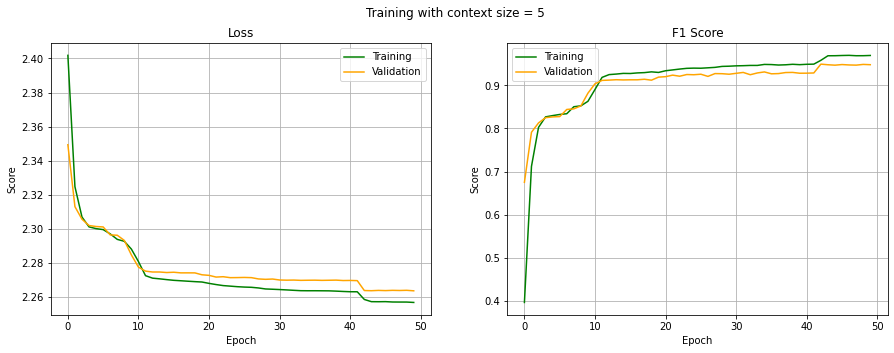

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9697, device='cuda:0'),
 tensor(0.9477, device='cuda:0'),
 tensor(0.9483, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9697, device='cuda:0'),
 tensor(0.9477, device='cuda:0'),
 tensor(0.9483, device='cuda:0'))

## Heatmap

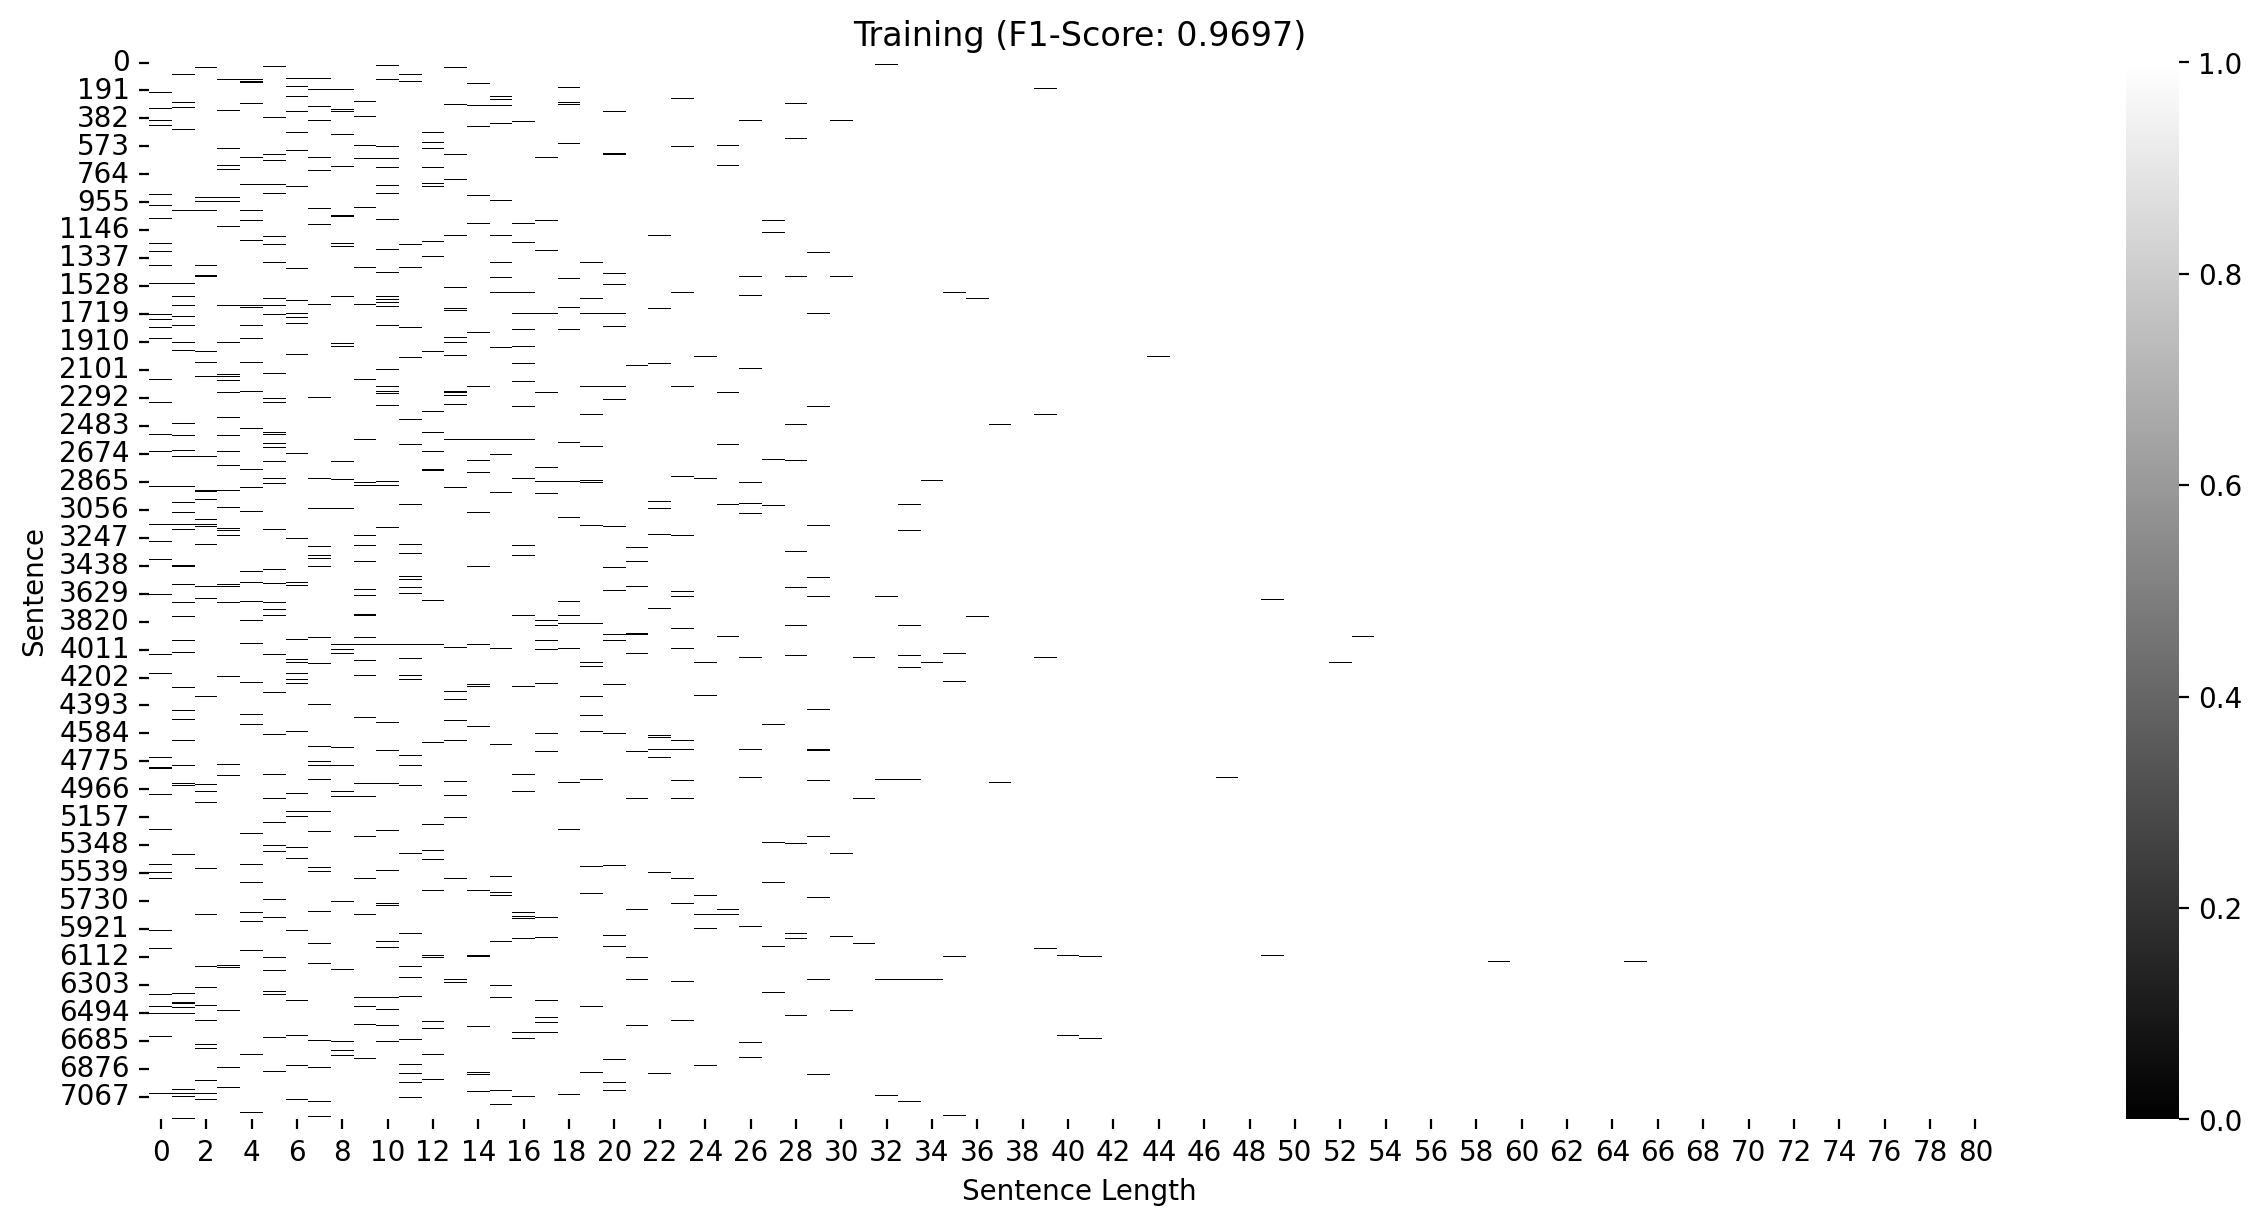

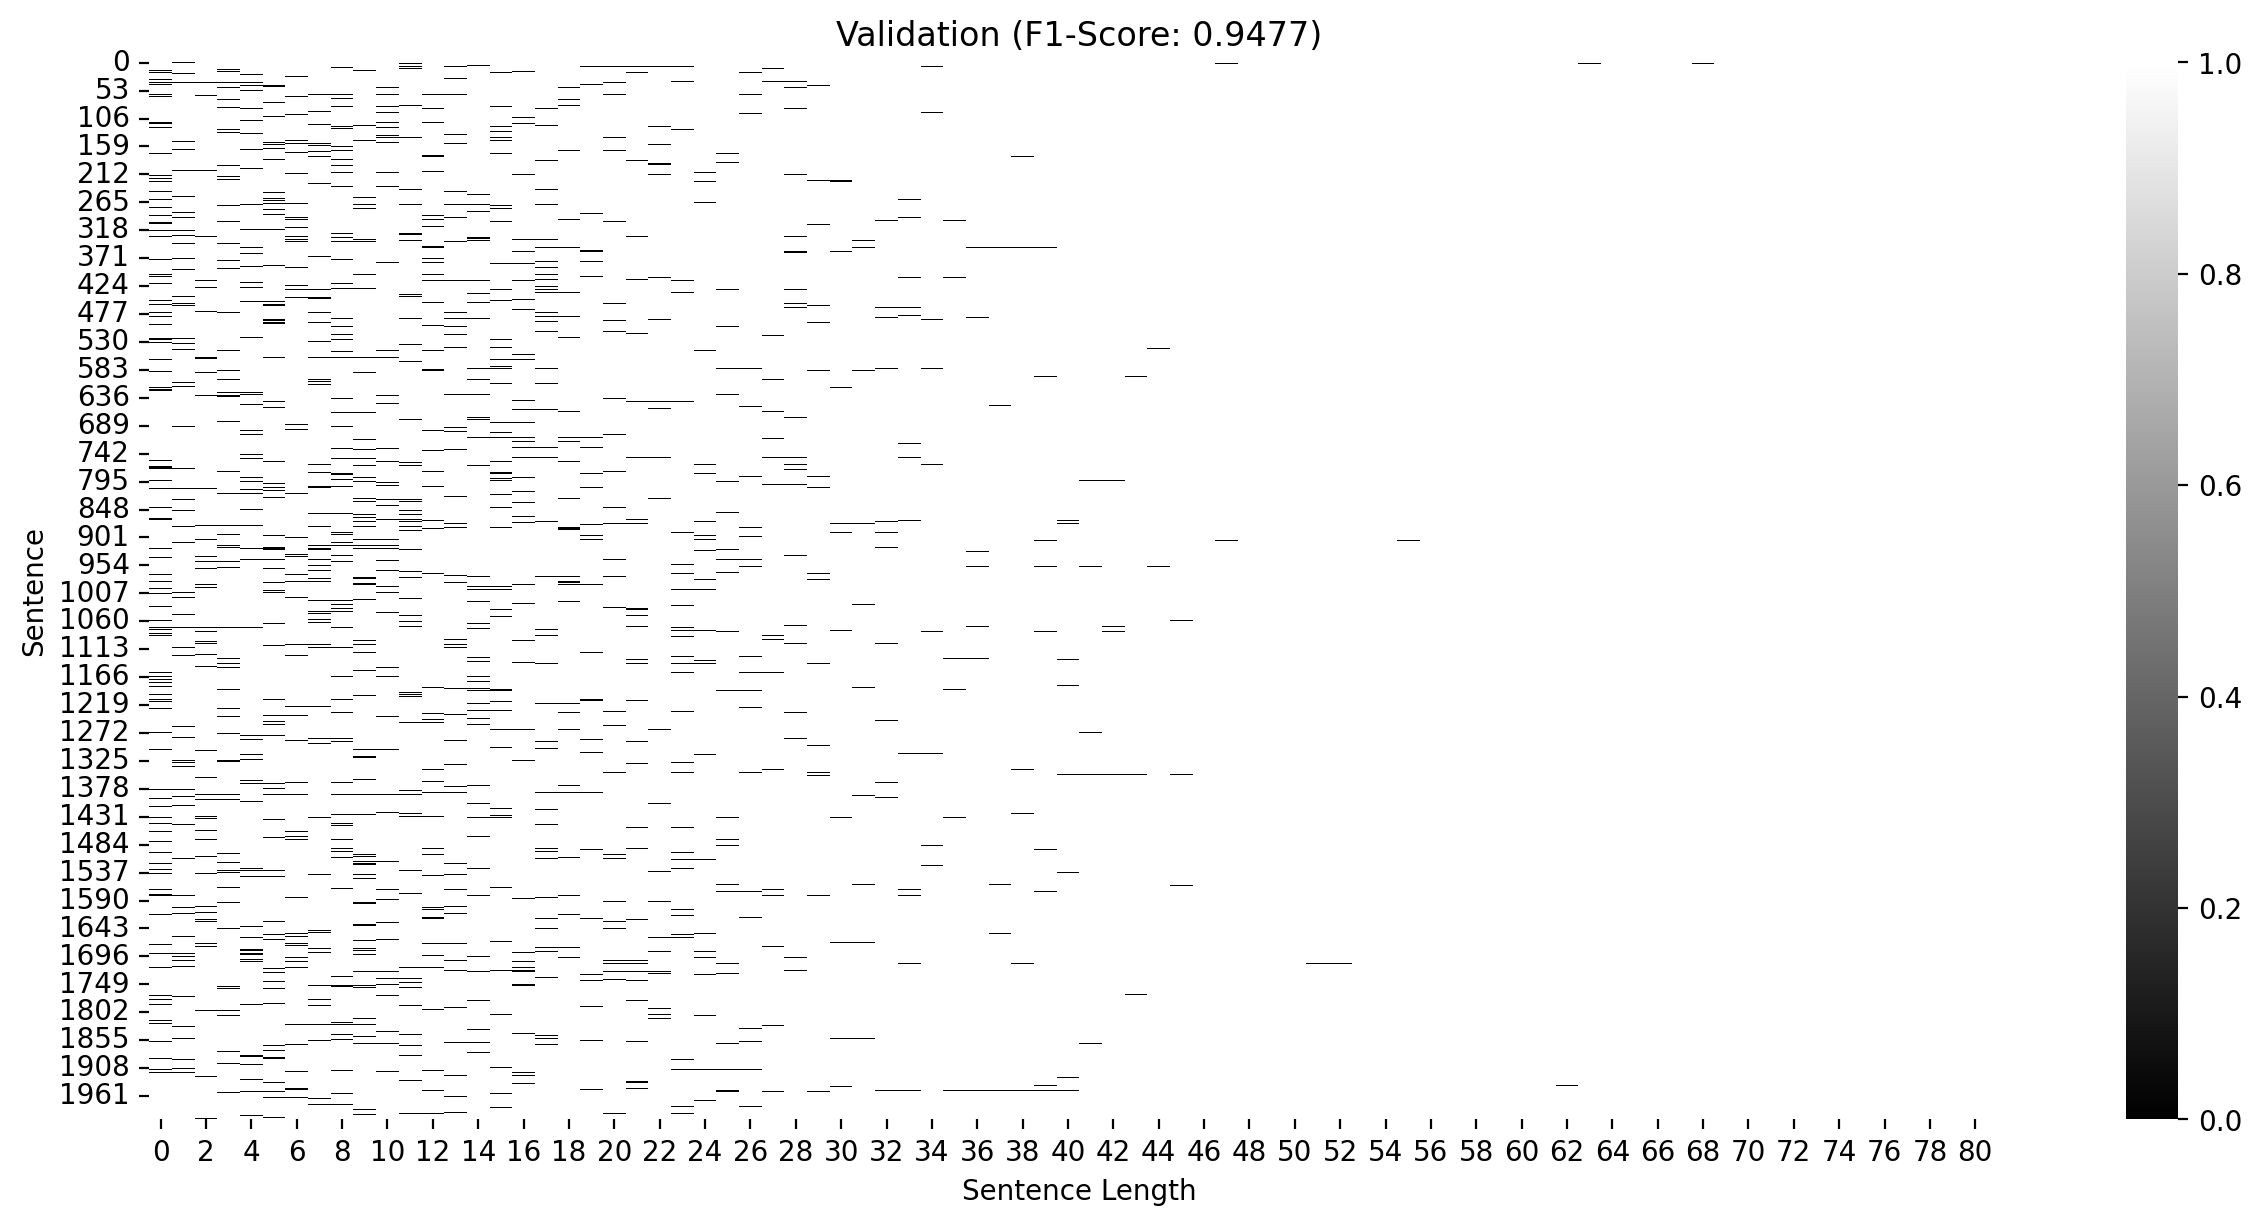

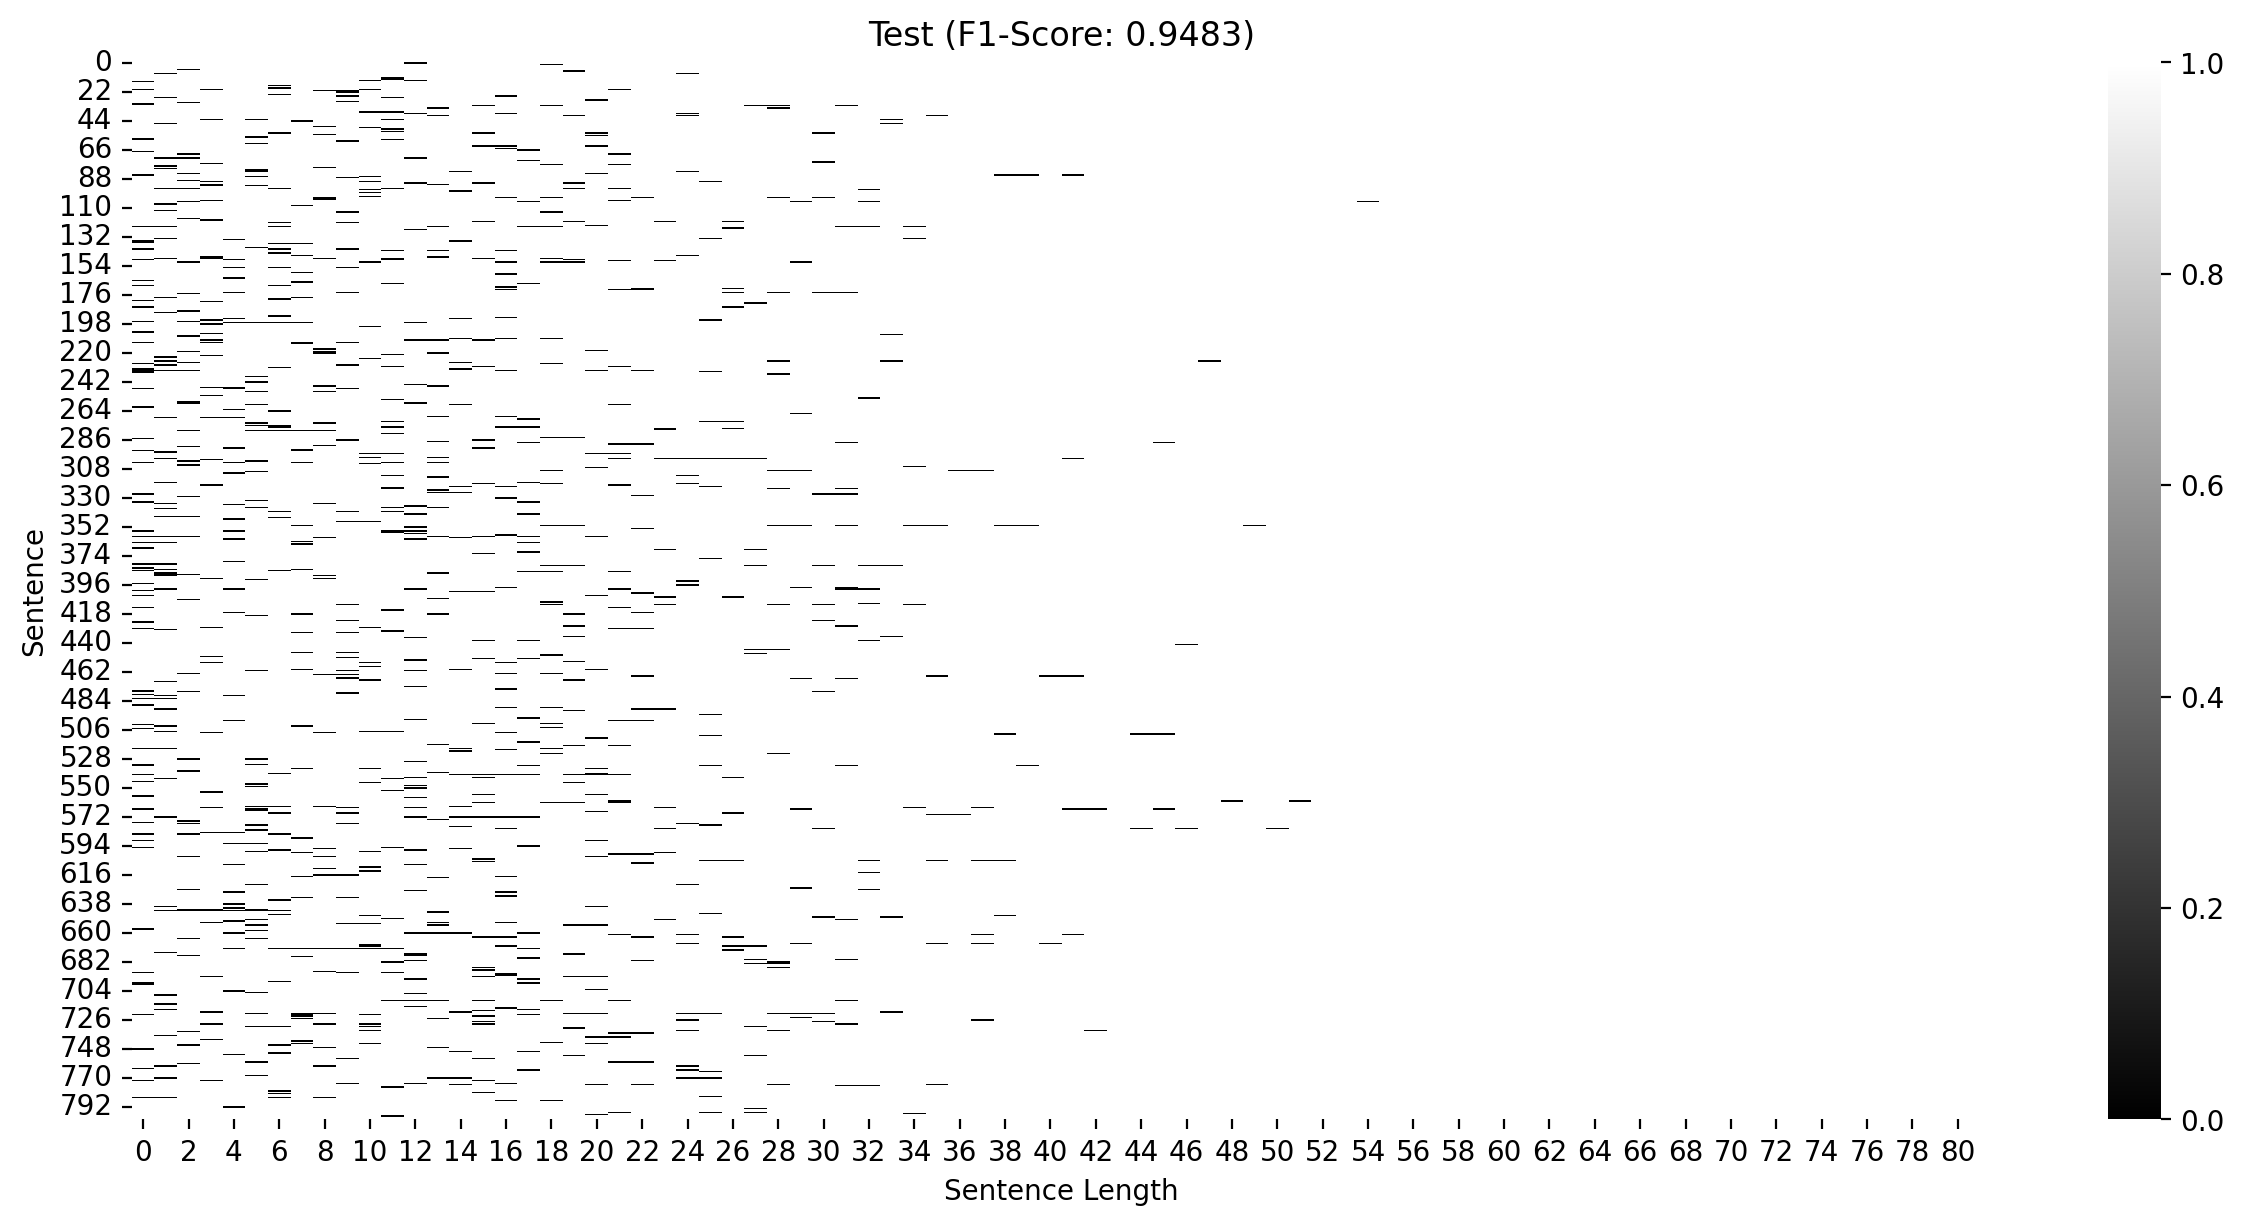

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


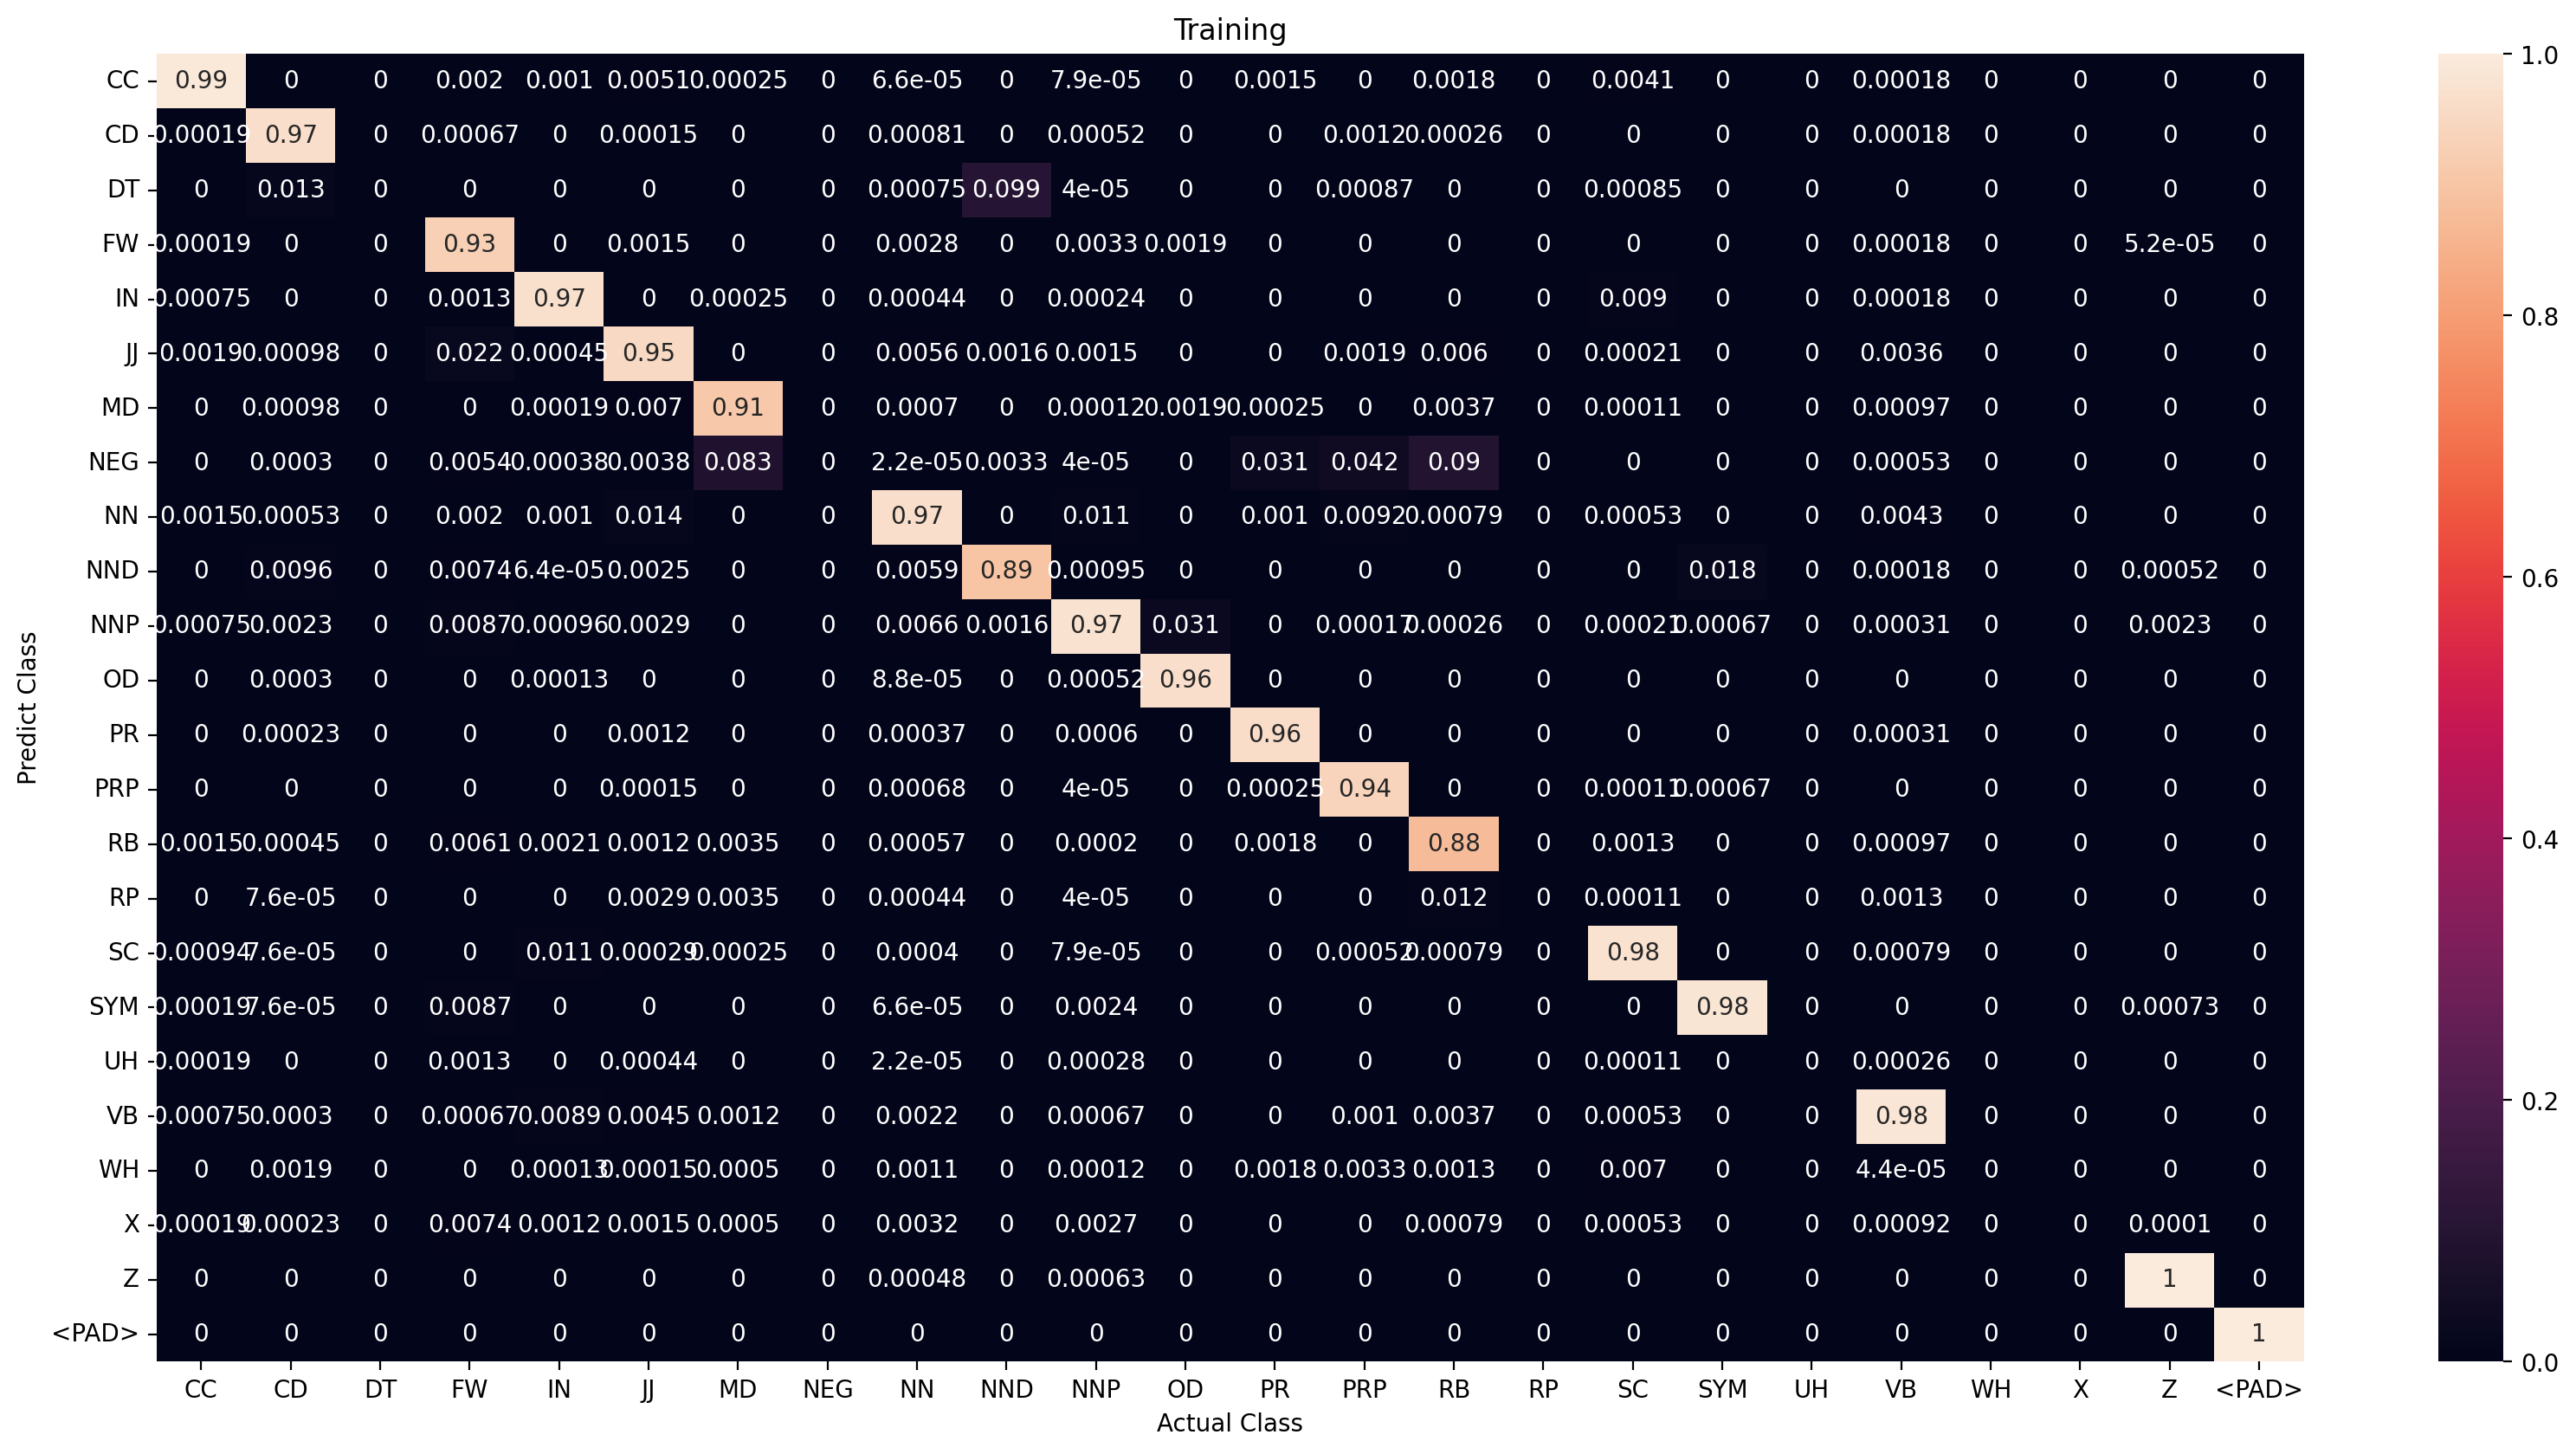

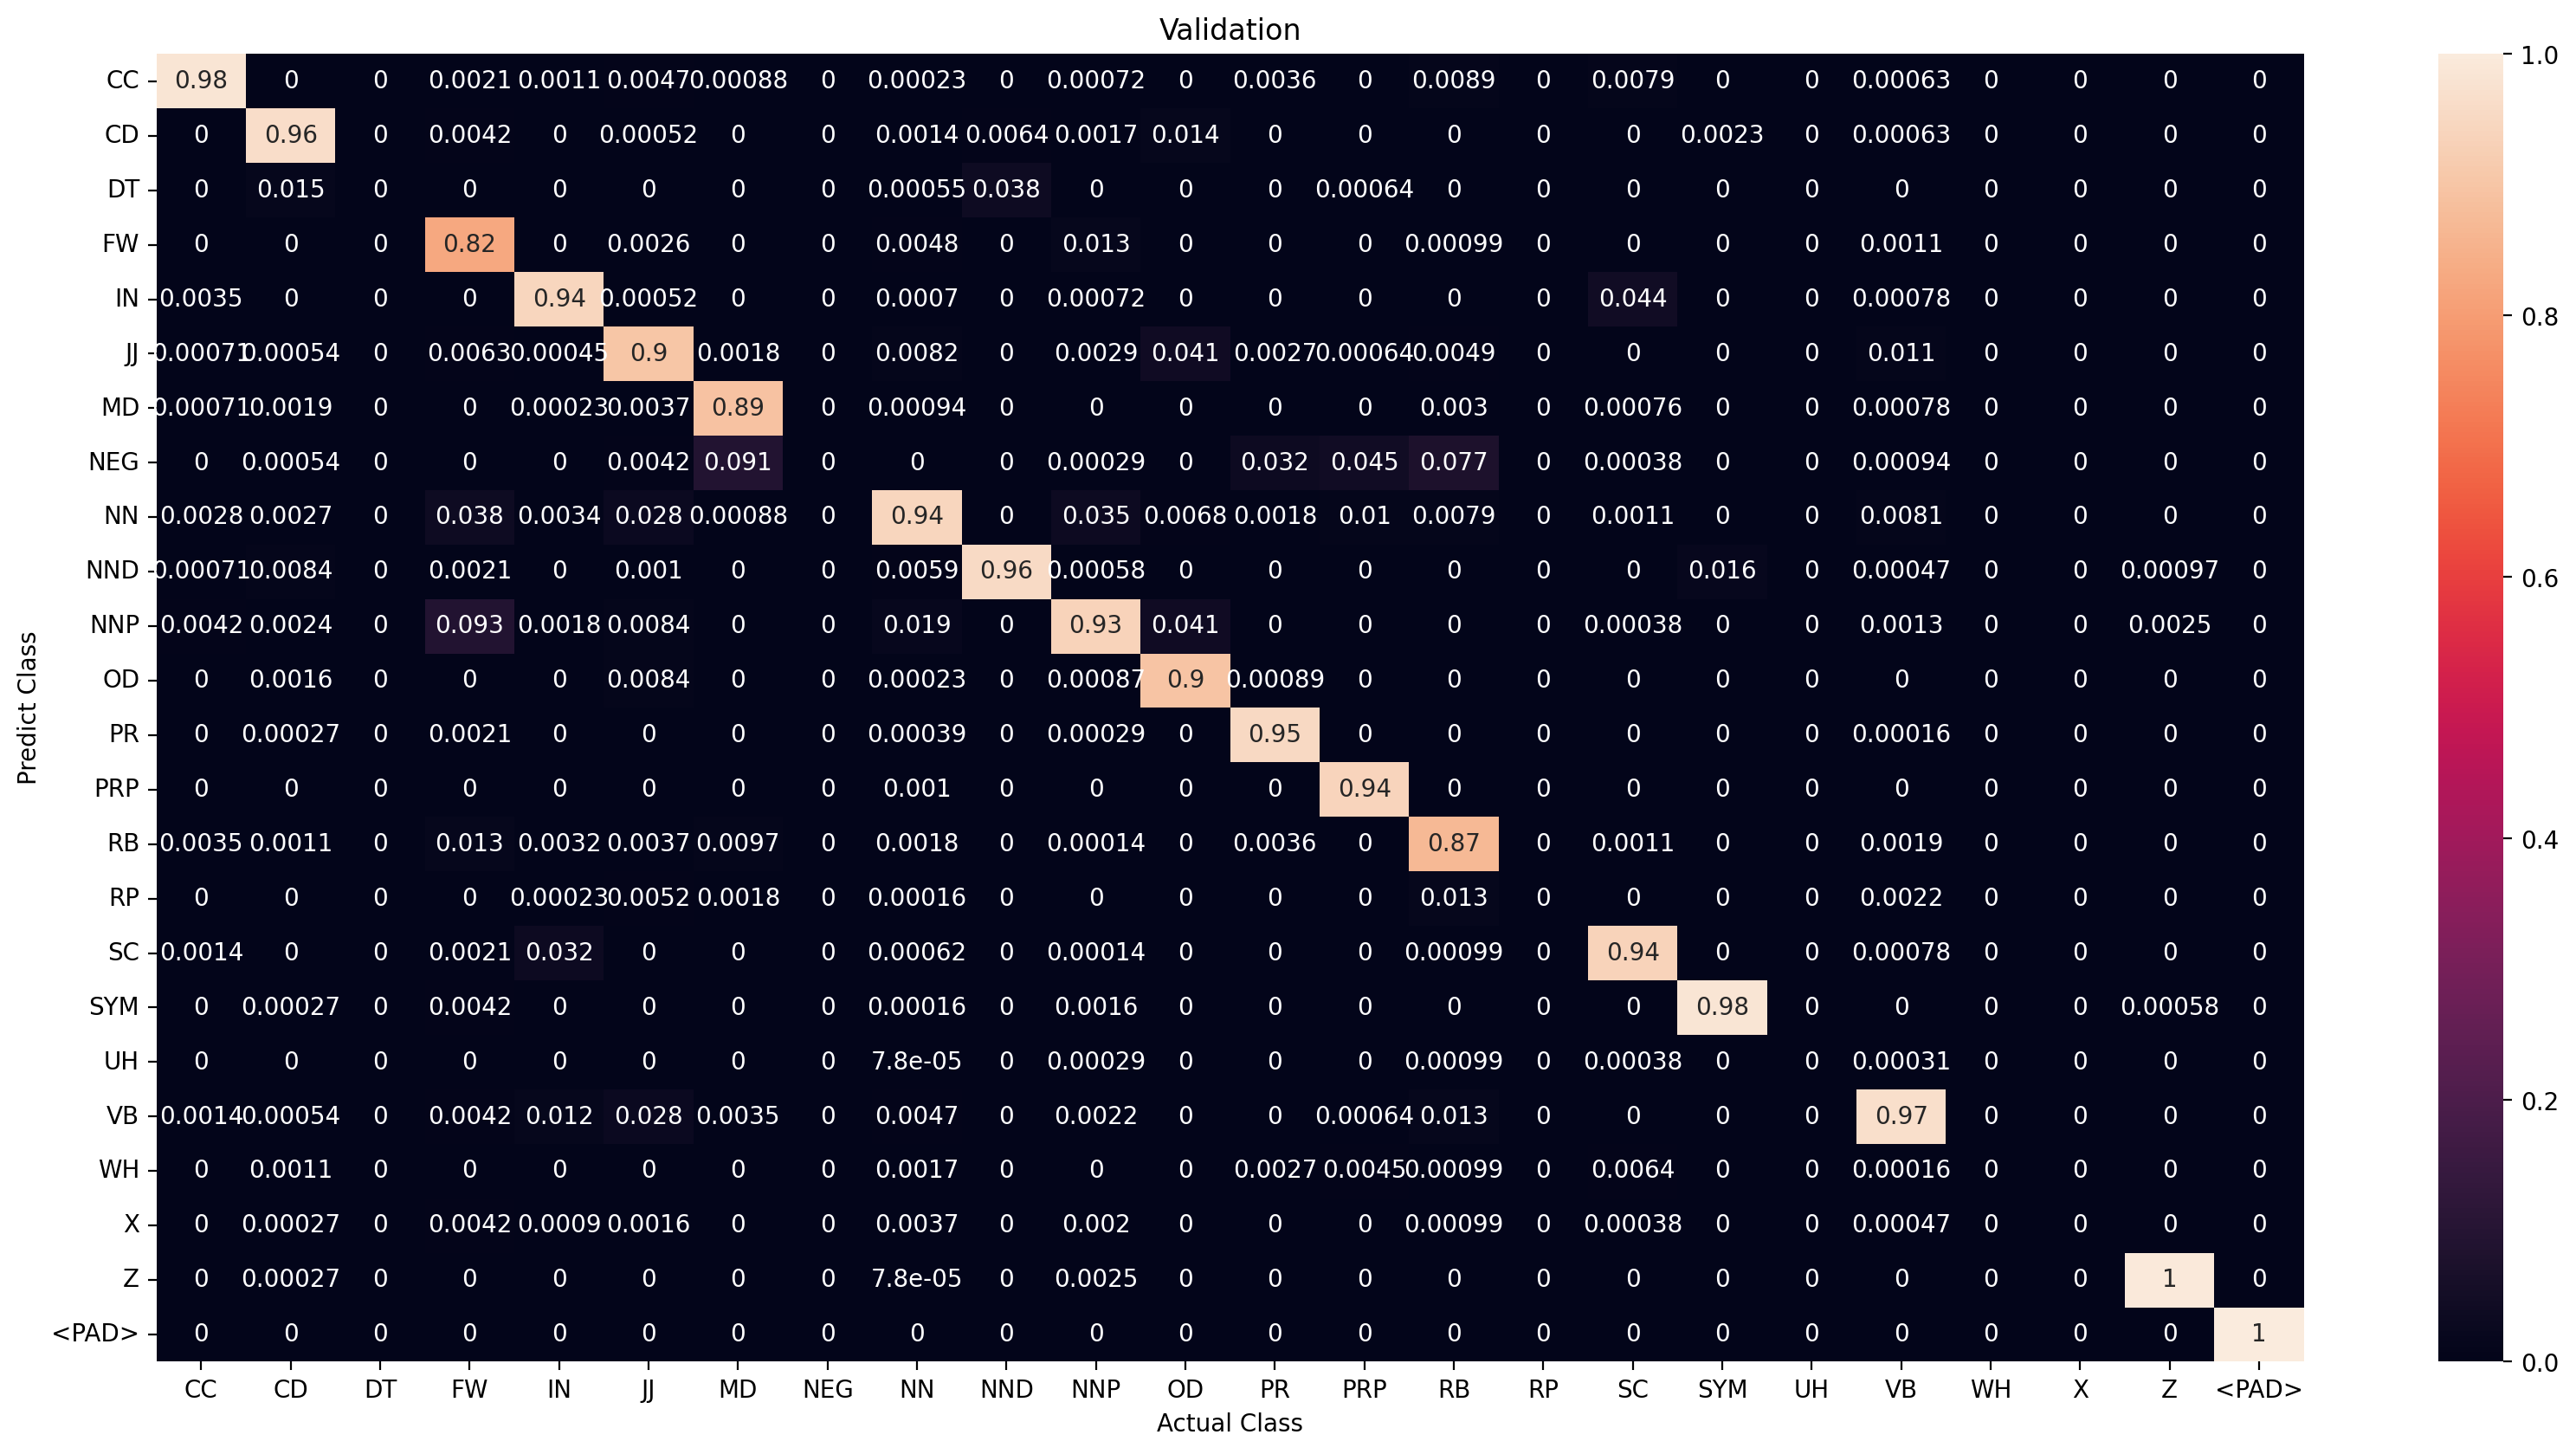

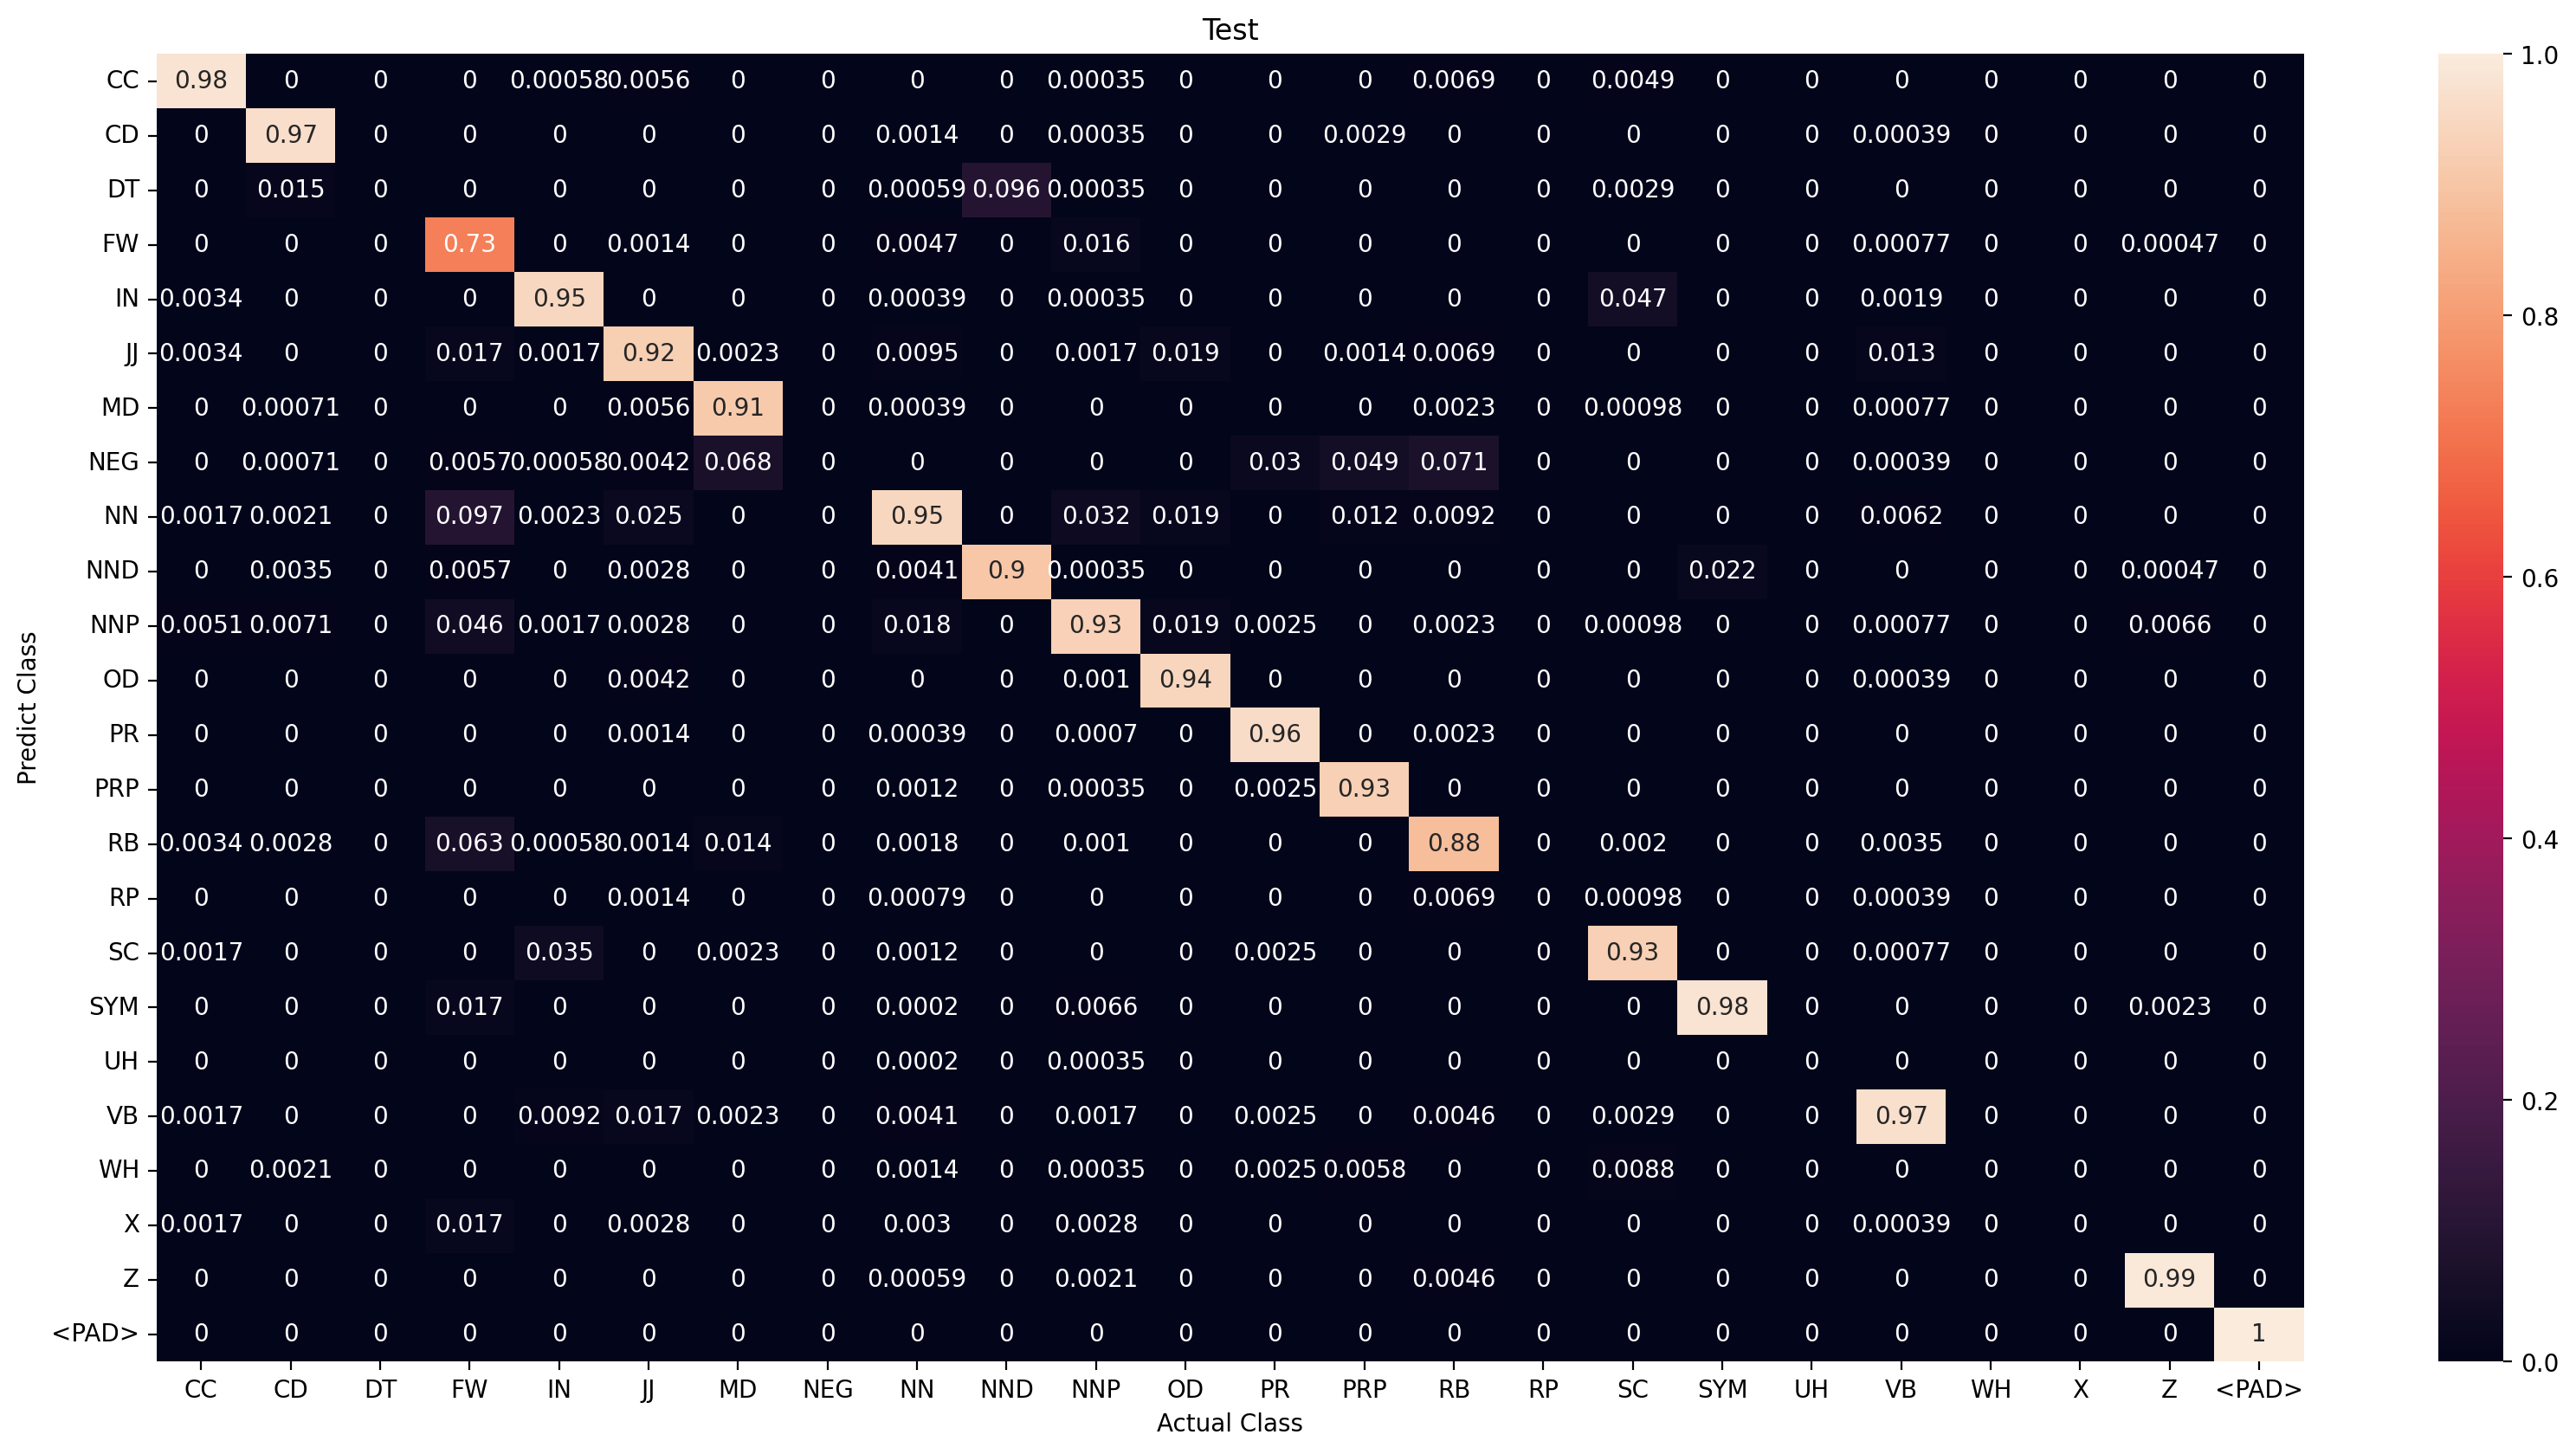

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5397   | CC    : 5281       | CC    : 116      |
| CD    : 12862  | CD    : 12797      | CD    : 65       |
| DT    : 278    | DT    : 0          | DT    : 278      |
| FW    : 1605   | FW    : 1376       | FW    : 229      |
| IN    : 15290  | IN    : 15168      | IN    : 122      |
| JJ    : 7025   | JJ    : 6551       | JJ    : 474      |
| MD    : 3798   | MD    : 3660       | MD    : 138      |
| NEG   : 1101   | NEG   : 0          | NEG   : 1101     |
| NN    : 44472  | NN    : 43907      | NN    : 565      |
| NND   : 1033   | NND   : 545        | NND   : 488      |
| NNP   : 25007  | NNP   : 24550      | NNP   : 457      |
| OD    : 519    | OD    : 496        | OD    : 23       |
| PR    : 3880   | PR    : 3830       | PR    : 50       |
| PRP   : 5449   | PRP   : 5413       | PRP   : 36       |
| RB    : 3502   | RB    : 3352       | RB    : 150      |
| RP    : 131    | RP    : 0          | RP    : 131     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8,  3, 12, 19,  8,  8,  8, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8,  8, 12, 19,  8,  8,  5, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([ True, False,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [ ]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [ ]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

In [ ]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

In [ ]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

In [ ]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);